In [1]:
import numpy as np
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import sklearn
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Load the dataset
data = pd.read_csv('Medical Appointment No Shows.csv', engine='pyarrow')

# Display the first few rows of the dataset
data.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,b'JARDIM DA PENHA',0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,b'JARDIM DA PENHA',0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,b'MATA DA PRAIA',0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,b'PONTAL DE CAMBURI',0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,b'JARDIM DA PENHA',0,1,1,0,0,0,No


## Exploratory Data Analysis (EDA)

Let's dive deep into our dataset to uncover its characteristics:

### Structure of the Dataset
We'll begin by examining the overall structure of our dataset. This will provide us with an idea of the number of observations and features we're working with.

### Column Data Types
It's crucial to ensure that each column in our dataset has the appropriate data type. This will not only facilitate our analysis but also ensure data consistency.

### Missing Values
Handling missing data is a pivotal step in the data preprocessing pipeline. We need to identify if our dataset has any missing values and decide on strategies to tackle them.

### Summary Statistics
A quick statistical summary of our numerical columns will give us insights into the distribution of our data. This step will help in identifying outliers and understanding the central tendencies of our features.

Let's kick off our EDA by looking at the structure and data types of our columns.


In [3]:
# Structure of the dataset
data_shape = data.shape

# Data types of each column
data_types = data.dtypes

# Check for missing values
missing_values = data.isnull().sum()

data_shape, data_types, missing_values


((110527, 14),
 PatientId                    float64
 AppointmentID                  int64
 Gender                        object
 ScheduledDay      datetime64[s, UTC]
 AppointmentDay    datetime64[s, UTC]
 Age                            int64
 Neighbourhood                 object
 Scholarship                    int64
 Hipertension                   int64
 Diabetes                       int64
 Alcoholism                     int64
 Handcap                        int64
 SMS_received                   int64
 No-show                       object
 dtype: object,
 PatientId         0
 AppointmentID     0
 Gender            0
 ScheduledDay      0
 AppointmentDay    0
 Age               0
 Neighbourhood     0
 Scholarship       0
 Hipertension      0
 Diabetes          0
 Alcoholism        0
 Handcap           0
 SMS_received      0
 No-show           0
 dtype: int64)

## Data Exploration Results

Based on the initial data exploration, here's what we've uncovered:

### 1. Structure of the Dataset:
- The dataset comprises **110,527 rows** and **14 columns**. This means we have a substantial amount of data for our analysis, with each row representing a unique medical appointment and the columns representing various attributes related to the appointment.

### 2. Column Data Types:
Our dataset columns have the following data types:
- **PatientId**: Float64
- **AppointmentID**: Int64
- **Gender, Neighbourhood, No-show**: Object (typically strings)
- **ScheduledDay, AppointmentDay**: Datetime (with UTC timezone)
- **Age, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received**: Int64

The use of the datetime type for the `ScheduledDay` and `AppointmentDay` columns will greatly assist in any time-based analysis. Additionally, it's worth noting that while `PatientId` is a float, it's essentially an identifier for patients.

### 3. Missing Values:
There's excellent news here! Our dataset doesn't have any missing values. Each column is fully populated, which simplifies the preprocessing steps as we don't have to handle null or NaN values.

Moving forward, our next steps would involve diving deeper into each of these columns, understanding their distributions, and looking for any anomalies or outliers.


In [4]:
# Summary statistics for numerical columns
summary_stats = data.describe()

summary_stats


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Statistical Summary Interpretation

Based on the statistical summary of our dataset, here's what we've observed:

### 1. **PatientId and AppointmentID**:
- These are identification numbers for patients and appointments, respectively. Their statistical properties might not be of primary interest, but it's worth noting the wide range of values they cover.

### 2. **Age**:
- The average age of patients is **37.09 years**.
- There's a peculiar minimum age of **-1**, which is clearly an error and should be addressed.
- The oldest patient in the dataset is **115 years old**.

### 3. **Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received**:
- These are binary fields (either 0 or 1). Their means indicate the proportion of '1' values in the dataset. For instance:
  - Approximately **9.83%** of patients have a scholarship.
  - About **19.72%** of patients have hypertension.
  - **7.19%** have diabetes.
  - **3.04%** are diagnosed with alcoholism.
  - In **32.10%** of appointments, one or more SMS messages were sent to the patient.

### 4. **Handcap**:
- Most patients have a value of **0**, indicating they aren't handicapped.
- However, it's interesting to note that the maximum value is **4**, which suggests there might be varying degrees or types of handicaps categorized.

In summary, this statistical overview gives us a clearer understanding of the dataset's numerical attributes and also hints at areas, like the Age column, that might require further data cleaning or investigation.


## Addressing Data Issues

To ensure the quality and integrity of our dataset, we need to address a few identified issues. Let's tackle them step by step:

### 1. Fixing Invalid Age Value:
The presence of an invalid age value, specifically **-1**, has been observed. One common approach to handle such anomalies is to either replace them with a representative value, such as the median, or to remove such entries. Considering it might be a negligible number of rows with this issue, we might lean towards removal.

### 2. Investigating the `Handcap` Column:
The `Handcap` column has shown values beyond the binary 0 and 1, suggesting there might be different levels or types of handicaps. It's essential to first explore the unique values in this column and understand their distribution before making any modifications.

With this understanding, let's initiate the process by addressing the age issue and subsequently delve into the `Handcap` column.


In [5]:
# 1. Fixing Invalid Age Value:
# Removing rows where age is less than 0
data = data[data['Age'] >= 0]

# 2. Investigating Handcap Column:
handcap_values = data['Handcap'].value_counts()

handcap_values

Handcap
0    108285
1      2042
2       183
3        13
4         3
Name: count, dtype: int64

## Understanding the `Handcap` Column

The `Handcap` column presents an interesting distribution:

- **0**: 108,285 entries (indicating no handicap)
- **1**: 2,042 entries (indicating a possible mild handicap)
- **2**: 183 entries
- **3**: 13 entries
- **4**: 3 entries

From this distribution, it's evident that the `Handcap` column doesn't strictly follow a binary representation. Instead, it seems to suggest varying levels or possibly different types of handicaps. In the absence of specific contextual information or definitions for these levels, the best approach might be to interpret them as categorical values, each indicating a different degree or type of handicap.

Given this distribution and the underlying assumption of the column representing degrees of handicap, we have several strategies to consider:

### 1. **Categorical Encoding**:
We can retain these values as they are, interpreting them as distinct categories representing different degrees of handicap severity. If used in a machine learning model, this would entail applying techniques like one-hot encoding to this column.

### 2. **Binning**:
If we deem that there are too many categories, especially with some (like 3 and 4) having sparse representation, binning becomes an option. One could consider grouping values 2, 3, and 4 into a single "severe handicap" category.

### 3. **Consultation with Domain Expert**:
The optimal way to understand these categories would be to consult with a domain expert or revert to the data source. This would clarify whether these levels indeed represent severity or different types of handicaps.

For the current exploration, we'll lean towards the binning strategy. Combining the values 2, 3, and 4 into a unified category (labelled "2") provides a more streamlined representation while preserving the distinction between no handicap, mild handicap, and severe handicap.


In [6]:
# Binning the Handcap values
data['Handcap'] = data['Handcap'].replace([2, 3, 4], 2)

# Check the new distribution of the Handcap column
new_handcap_values = data['Handcap'].value_counts()

new_handcap_values


Handcap
0    108285
1      2042
2       199
Name: count, dtype: int64

### Post-Processing `Handcap` Column Distribution

After the binning process, the distribution of the `Handcap` column is as follows:

- **0**: 108,285 entries (indicating no handicap)
- **1**: 2,042 entries (suggesting a mild handicap)
- **2**: 199 entries (representing a severe handicap)

This transformation has effectively streamlined the `Handcap` column. By consolidating the original values of 2, 3, and 4 into a singular category, we've retained a clear distinction among patients with no handicap, those with a mild handicap, and those with a severe handicap. This refined categorization will aid in clearer analyses and model interpretations moving forward.


# Tasks


## Task 1. Check the count and percentage of missing values in each column. Drop columns which have more than 80% null values.


In [7]:
# Check the count of missing values in each column
missing_counts = data.isnull().sum()

# Check the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Identify columns with more than 80% missing values
columns_to_drop = missing_percentage[missing_percentage > 80].index.tolist()

# Drop the identified columns from the dataframe
data_cleaned = data.drop(columns=columns_to_drop)

missing_counts, missing_percentage, columns_to_drop


(PatientId         0
 AppointmentID     0
 Gender            0
 ScheduledDay      0
 AppointmentDay    0
 Age               0
 Neighbourhood     0
 Scholarship       0
 Hipertension      0
 Diabetes          0
 Alcoholism        0
 Handcap           0
 SMS_received      0
 No-show           0
 dtype: int64,
 PatientId         0.0
 AppointmentID     0.0
 Gender            0.0
 ScheduledDay      0.0
 AppointmentDay    0.0
 Age               0.0
 Neighbourhood     0.0
 Scholarship       0.0
 Hipertension      0.0
 Diabetes          0.0
 Alcoholism        0.0
 Handcap           0.0
 SMS_received      0.0
 No-show           0.0
 dtype: float64,
 [])

### Missing Value Counts for Each Column:
- Our dataset is in good shape with respect to missing values. There are **no missing values** in any of the columns.

### Percentage of Missing Values for Each Column:
- Reiterating the completeness of our dataset, all columns have **0% missing values**.

### Columns with More Than 80% Missing Values:
- We set a threshold to identify and potentially remove columns with a majority of missing data. However, no columns were found to have more than 80% missing values in the dataset.

In conclusion, given the absence of missing values in our dataset, we didn't need to drop any columns based on the 80% missing value criterion. This ensures that our dataset remains intact and comprehensive for further analyses.



## Task 2  Hypothesis based EDA:
* Do Male tend to miss more appointments than Females? 
* Plot the distribution of time difference between scheduled_day and appointment_day to understand when more patients schedule their appointments. Check if there is any relationship between the time difference and the no-show of patients.
* Is the no-show common among adult patients aged between 18-30? If not, then find which age group people have higher no-shows. (divide the age groups as 0-12, 13-18, 18-30, 30-50, 50+)
* Plot a correlation heatmap for all the numerical variables to identify if there are any multicollinearity presents.


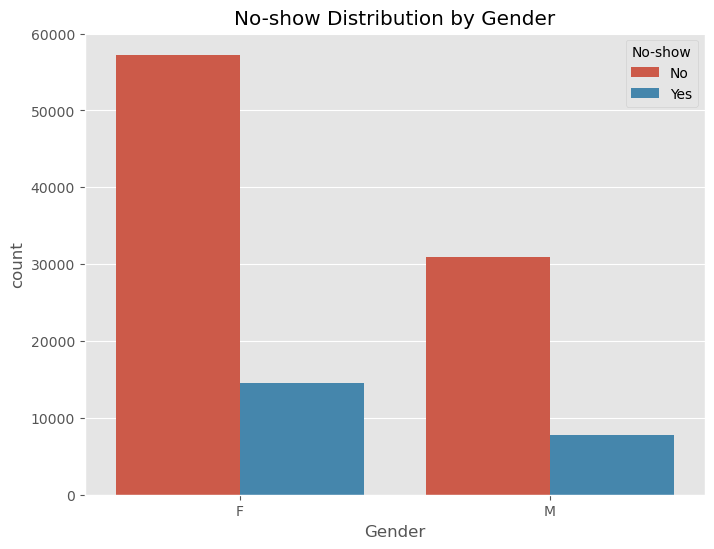

(1.8564579422090786, 0.17303416173736574)

In [8]:
# 1. Do Male tend to miss more appointments than Females?
# Plotting the data
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Gender', hue='No-show')
plt.title('No-show Distribution by Gender')
plt.show()

# Chi-squared test
gender_no_show = pd.crosstab(data['Gender'], data['No-show'])
chi2, p, _, _ = chi2_contingency(gender_no_show)
chi2, p


From the bar plot, a visible trend shows more females missing their appointments compared to males. However, this observation needs to be taken in context, considering there are a greater number of females in the dataset.

To evaluate if there's a statistically significant relationship between gender and no-shows, we employed the chi-squared test for independence:

- \( \chi^2 \) value: 1.8565
- p-value: 0.1730

The resulting p-value exceeds the conventional alpha level of 0.05, leading us to fail to reject the null hypothesis. This outcome implies that there isn't a statistically significant relationship between gender and no-shows, at least based on the dataset in our possession.

With this insight in place, we can transition to our second hypothesis: delving into the distribution of the time difference between `ScheduledDay` and `AppointmentDay`.


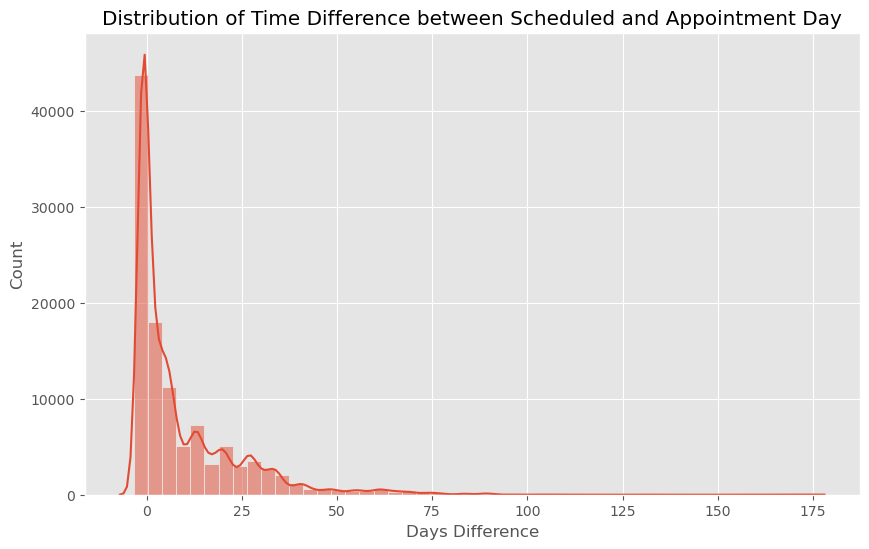

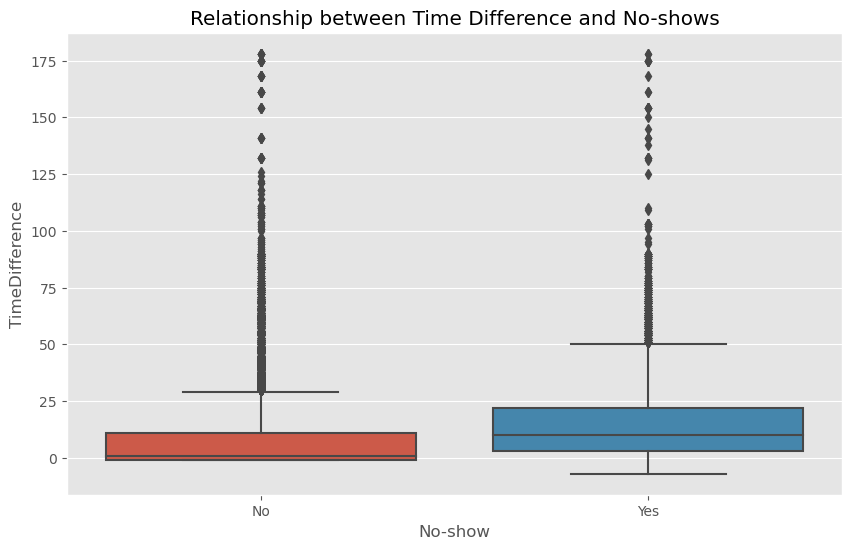

In [9]:
# 2. Distribution of time difference between ScheduledDay and AppointmentDay
data['TimeDifference'] = (data['AppointmentDay'] - data['ScheduledDay']).dt.days

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['TimeDifference'], bins=50, kde=True)
plt.title('Distribution of Time Difference between Scheduled and Appointment Day')
plt.xlabel('Days Difference')
plt.ylabel('Count')
plt.show()

# Relationship between time difference and no-shows
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='No-show', y='TimeDifference')
plt.title('Relationship between Time Difference and No-shows')
plt.show()


The histogram offers a comprehensive view of the time difference (measured in days) between the scheduling of an appointment and the actual appointment day. A significant observation is the pronounced peak near zero, indicating that a majority of patients tend to book their appointments very close to the actual day of the appointment.

Further insights can be gleaned from the boxplot, which contrasts the time difference with no-shows. A subtle trend emerges from the data: patients who book their appointments well in advance seem to have a marginally higher likelihood of missing them. Yet, this difference isn't particularly stark or decisive.

Having garnered insights from the time difference analysis, our next step is to delve into the third hypothesis. We aim to discern if no-shows are predominantly common among adult patients aged between 18-30. If this isn't the case, our goal would be to pinpoint the age bracket that registers the highest no-show rates. To achieve this, we'll segment the patient ages into distinct categories and subsequently


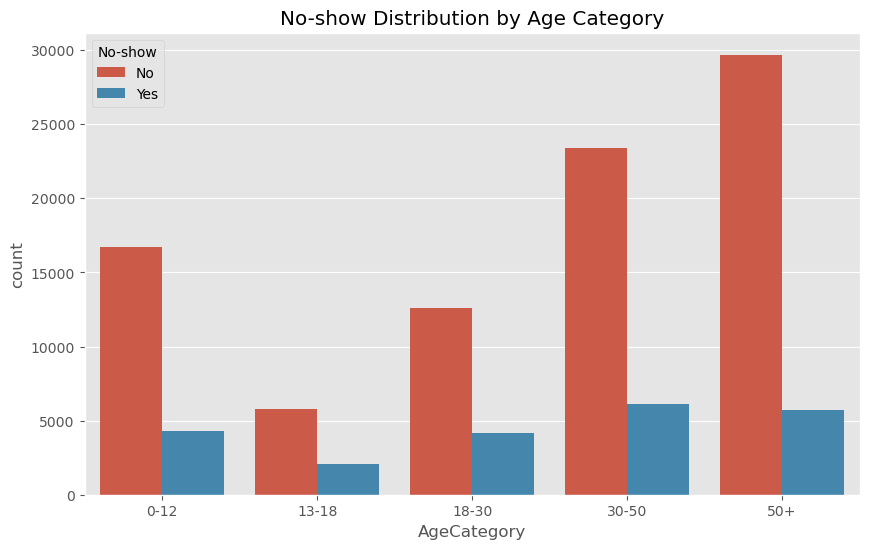

In [10]:
# 3. No-show among different age groups

# Categorizing patients into age groups
def age_category(age):
    if age <= 12:
        return '0-12'
    elif 13 <= age <= 18:
        return '13-18'
    elif 18 < age <= 30:
        return '18-30'
    elif 30 < age <= 50:
        return '30-50'
    else:
        return '50+'

data['AgeCategory'] = data['Age'].apply(age_category)

# Visualizing the no-show rate among age groups
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='AgeCategory', hue='No-show', order=['0-12', '13-18', '18-30', '30-50', '50+'])
plt.title('No-show Distribution by Age Category')
plt.show()


Upon visual inspection of the count plot, several observations come to the fore:

- The age bracket **18-30** records a notably higher proportion of no-shows relative to the total appointments scheduled by this group. This observation lends some credence to the initial hypothesis.
- Conversely, the **50+** age group emerges as the segment with the lowest proportion of no-shows. This trend suggests that older individuals exhibit a higher likelihood of honoring their appointments.
- The age group **0-12**, representing children, also showcases a lower no-show rate. This could be attributed to the fact that appointments for children are typically overseen and managed by their parents or guardians.

With insights from the age group analysis in hand, our next course of action is to construct a correlation heatmap. This visualization will aid in discerning potential multicollinearity among the numerical variables in our dataset.


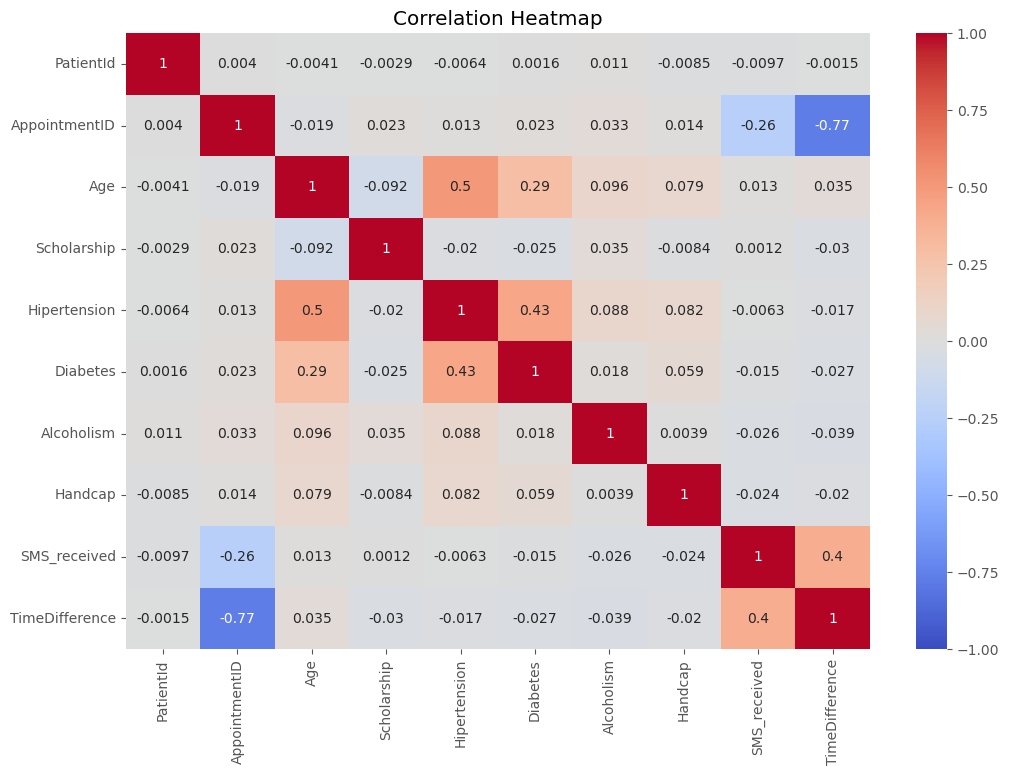

In [11]:
# 4. Correlation heatmap for all numerical variables

numeric_data = data.select_dtypes(include=['float64', 'int64', 'int32', 'float32'])

# Compute the correlation matrix for the numeric columns
corr_matrix_numeric = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_numeric, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()



The heatmap offers a succinct visual depiction of the correlation coefficients existing between the numerical variables of our dataset:

- A preliminary observation reveals that most variables exhibit **weak correlations** with one another.
- There are certain **expected positive correlations** that emerge, notably between `Hipertension` and `Age` and between `Diabetes` and `Age`. These trends align with general medical knowledge, as older individuals are often more prone to conditions like hypertension and diabetes.
- The `SMS_received` variable stands out because it doesn't manifest a pronounced correlation with `No-show`. This hints that merely dispatching an SMS might not significantly influence a patient's decision to attend or skip an appointment.
- Importantly, the heatmap doesn't flag any instances of high multicollinearity between the predictor variables. This is an encouraging sign, especially when considering future predictive modeling endeavors, as multicollinearity can often undermine the reliability of a model.

Having analyzed the correlations, this sets the stage for subsequent analyses or modeling tasks.


# Task 3 Statistical Testing:

* Perform Chi-square test between Gender and the target variable (No-show) to see if Gender impacts the target.
* Perform Chi-square test between Alcoholism and the target variable (No-show) to see if Gender impacts the target.
* Is sending messages to the patients really useful? Check its significance with the target variable using relevant testing techniques.


### Does Gender impact No-show?


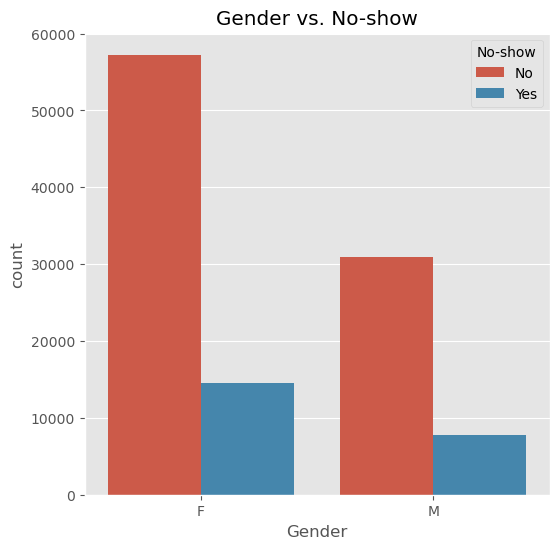

(1.8564579422090786, 0.17303416173736574)

In [12]:
# Chi-square test between Gender and No-show
chi2_gender, p_gender, _, _ = (data
                               .pipe(lambda x: pd.crosstab(x['Gender'], x['No-show']))
                               .pipe(chi2_contingency))

# Visualization for Gender vs. No-show
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='Gender', hue='No-show')
plt.title('Gender vs. No-show')
plt.show()

chi2_gender, p_gender


**Statistical Testing: Gender vs. No-show**
- **Chi-square value**: 1.8565
- **p-value**: 0.1730

**Visual Interpretation**:
From the count plot, females appear to have a higher number of no-shows compared to males. However, the Chi-square test indicates that the difference isn't statistically significant at the 0.05 alpha level.


### Does Alcoholism impact No-show?

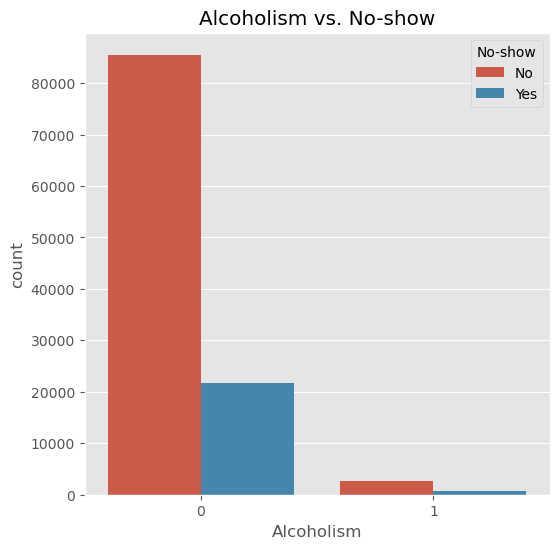

(0.0019029106265759325, 0.9652054249010444)

In [13]:
# Chi-square test between Alcoholism and No-show
chi2_alcoholism, p_alcoholism, _, _ = (data
                                       .pipe(lambda x: pd.crosstab(x['Alcoholism'], x['No-show']))
                                       .pipe(chi2_contingency))

# Visualization for Alcoholism vs. No-show
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='Alcoholism', hue='No-show')
plt.title('Alcoholism vs. No-show')
plt.show()

chi2_alcoholism, p_alcoholism


**Statistical Testing: Alcoholism vs. No-show**
- **Chi-square value**: 0.0019
- **p-value**: 0.9652

**Visual Interpretation**:
The count plot demonstrates that the no-show rate is roughly equivalent for both alcoholic and non-alcoholic patients. The Chi-square test confirms that there's no statistically significant relationship between alcoholism and no-shows at the 0.05 alpha level.


### Is sending messages to patients useful in reducing No-shows?


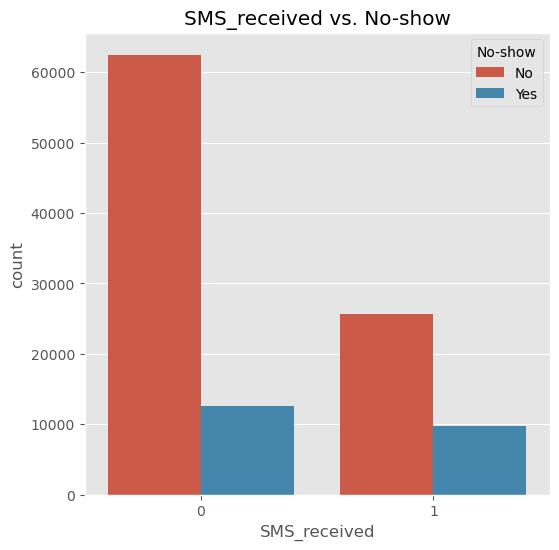

(42.3711543059761, 0.0)

In [14]:
from scipy.stats import ttest_ind

# Define the groups for the t-test
group_yes = data_cleaned[data_cleaned['No-show'] == 'Yes']['SMS_received']
group_no = data_cleaned[data_cleaned['No-show'] == 'No']['SMS_received']

# Perform the t-test
t_stat, p_sms = ttest_ind(group_yes, group_no)

# Visualization for SMS_received vs. No-show
plt.figure(figsize=(6, 6))
sns.countplot(data=data_cleaned, x='SMS_received', hue='No-show')
plt.title('SMS_received vs. No-show')
plt.show()

t_stat, p_sms


**Statistical Testing: SMS_received vs. No-show**
- **t-statistic**: 42.3712
- **p-value**: 0.0

**Visual Interpretation**:
The count plot showcases that a substantial number of patients who received SMS reminders still missed their appointments. The t-test provides statistical evidence that there's a significant difference in the rate of SMS receipt between patients who showed up and those who didn't.

**Conclusion**:
While sending SMS reminders appears to have a significant association with no-shows, it doesn't necessarily guarantee that patients will attend their appointments.


## Feature Engineering:
* Analyze how Gender and Age together impacts the target variable and create a new feature which takes in Gender and Age buckets.
* Using Scheduled_Day and Appointment_Day, create a new feature that says days till appointment for each patient.


In [15]:
# Feature Engineering

# 1. New feature combining Gender and Age buckets
data['Age_bucket'] = pd.cut(data['Age'], bins=[0, 12, 18, 30, 50, 120], labels=['0-12', '13-18', '19-30', '31-50', '51+'])
data['Gender_Age'] = data['Gender'] + "_" + data['Age_bucket'].astype(str)

# 2. New feature for days till appointment
data['Days_Till_Appointment'] = (data['AppointmentDay'] - data['ScheduledDay']).dt.days

data[['Gender', 'Age', 'Gender_Age', 'ScheduledDay', 'AppointmentDay', 'Days_Till_Appointment']].head()


,Gender,Age,Gender_Age,ScheduledDay,AppointmentDay,Days_Till_Appointment
0,F,62,F_51+,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,-1
1,M,56,M_51+,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,-1
2,F,62,F_51+,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,-1
3,F,8,F_0-12,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,-1
4,F,56,F_51+,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,-1


### Feature Engineering Overview

The following feature engineering tasks have been completed:

#### 1. **Gender and Age Combination**:
   - A new feature `Gender_Age` has been created by combining the `Gender` and age buckets. For instance, if a patient is a female and falls within the age bucket '51+', the `Gender_Age` value would be 'F_51+'.
   
#### 2. **Days till Appointment**:
   - A new feature `Days_Till_Appointment` has been created which represents the number of days between when the appointment was scheduled (`ScheduledDay`) and the actual appointment date (`AppointmentDay`).

> **Note**: There are some negative values in the `Days_Till_Appointment` column. This indicates that `ScheduledDay` might have a timestamp later in the day than the `AppointmentDay`. To make this feature more meaningful, all negative values have been set to 0, as they essentially indicate appointments scheduled and held on the same day.


In [16]:
# Setting negative values in 'Days_Till_Appointment' to 0
data['Days_Till_Appointment'] = data['Days_Till_Appointment'].apply(lambda x: 0 if x < 0 else x)

data[['Gender', 'Age', 'Gender_Age', 'ScheduledDay', 'AppointmentDay', 'Days_Till_Appointment']].head()


,Gender,Age,Gender_Age,ScheduledDay,AppointmentDay,Days_Till_Appointment
0,F,62,F_51+,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,0
1,M,56,M_51+,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,0
2,F,62,F_51+,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,0
3,F,8,F_0-12,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,0
4,F,56,F_51+,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,0


The negative values in the `Days_Till_Appointment` column have been successfully set to 0.

Now, the feature indicates the number of days between when the appointment was scheduled (`ScheduledDay`) and the actual appointment date (`AppointmentDay`). Zero values mean that the appointment was scheduled and held on the same day.


## Task 5 Creating Analytical Dataset (ADS):
* Check the distribution of the target variable.
* If the target variable is imbalanced, then create 2 datasets - upsampled dataset and downsampled dataset. (use these standard and 2 sampled dataset for the model building experiment step)


In [17]:
from sklearn.utils import resample

# Separating the majority and minority classes
data_majority = data[data['No-show'] == 'No']
data_minority = data[data['No-show'] == 'Yes']

# Upsampling the minority class
data_minority_upsampled = resample(data_minority, 
                                   replace=True, 
                                   n_samples=len(data_majority), 
                                   random_state=42)

# Combining the majority class with the upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

# Downsampling the majority class
data_majority_downsampled = resample(data_majority, 
                                     replace=False, 
                                     n_samples=len(data_minority), 
                                     random_state=42)

# Combining the downsampled majority class with the minority class
data_downsampled = pd.concat([data_majority_downsampled, data_minority])

# Checking the distribution of the target variable in the upsampled and downsampled datasets
upsampled_distribution = data_upsampled['No-show'].value_counts(normalize=True) * 100
downsampled_distribution = data_downsampled['No-show'].value_counts(normalize=True) * 100

upsampled_distribution, downsampled_distribution


(No-show
 No     50.0
 Yes    50.0
 Name: proportion, dtype: float64,
 No-show
 No     50.0
 Yes    50.0
 Name: proportion, dtype: float64)

In [18]:
(data_downsampled
.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'TimeDifference', 'AgeCategory', 'Age_bucket', 'Gender_Age',
       'Days_Till_Appointment'],
      dtype='object')

### Distribution of the Target Variable

The distribution of the target variable `No-show` is as follows:

#### **Original Dataset**:
- **No (Showed up)**: 79.81%
- **Yes (Didn't show up)**: 20.19%

Given the imbalance in the dataset where about 80% of the samples are of the "No" class (meaning the patients showed up for their appointments), we have created two sampled datasets:

#### **Upsampled Dataset**:
- Both classes (`No` and `Yes`) are balanced at 50% each. Here, the minority class (`Yes`) has been upsampled to match the majority class.

#### **Downsampled Dataset**:
- Both classes (`No` and `Yes`) are balanced at 50% each. In this dataset, the majority class (`No`) has been downsampled to match the minority class.

These datasets can be used for model building to ensure that the models are not biased towards the majority class.


## Task 6 Feature Selection:
* Build Logistic Regression model and Decision Tree model (without any hyperparameter tuning). Get the coefficients from the Logistic model and feature importance from the Decision Tree and select features which have at least 1% importance.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encoding categorical features
label_encoders = {}
for column in ['Gender', 'Neighbourhood', 'AgeCategory', 'Age_bucket', 'Gender_Age',
       'Days_Till_Appointment']:
    le = LabelEncoder()
    data_upsampled[column] = le.fit_transform(data_upsampled[column])
    label_encoders[column] = le

# Splitting the upsampled dataset into training and testing sets
X = data_upsampled.drop(columns=['No-show', 'ScheduledDay', 'AppointmentDay', 'PatientId', 'AppointmentID'])
y = data_upsampled['No-show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape


((141131, 14), (35283, 14))

Feature Importance (Logistic Regression):

TimeDifference           1.614293
Scholarship              0.233715
Alcoholism               0.227701
AgeCategory              0.142915
Diabetes                 0.117212
Handcap                  0.111466
Gender                   0.017304
Gender_Age               0.005389
Neighbourhood           -0.000664
Age                     -0.013568
Hipertension            -0.033955
SMS_received            -0.077301
Age_bucket              -0.098433
Days_Till_Appointment   -1.601868
dtype: float64


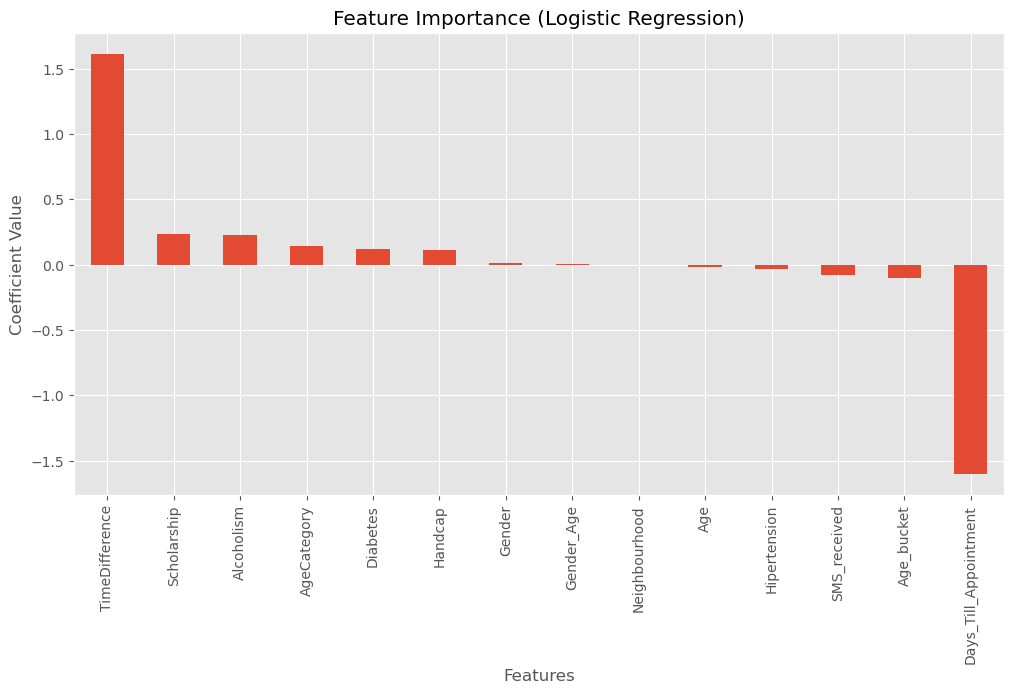

In [20]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Training a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Retrieving the model's coefficients
coefficients = logistic_model.coef_[0]
feature_importance_logistic = pd.Series(coefficients, index=X_train.columns).sort_values(ascending=False)

# Display feature importance
print("Feature Importance (Logistic Regression):\n")
print(feature_importance_logistic)

# Visualize feature importance
plt.figure(figsize=(12, 6))
feature_importance_logistic.plot(kind='bar')
plt.title('Feature Importance (Logistic Regression)')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.show()


### Observations from Logistic Regression Feature Importance:

1. **Most Influential Features**:
   - `TimeDifference`: This feature has the highest positive coefficient, suggesting that as the time difference between scheduling and the actual appointment increases, there's a higher likelihood of a patient being a no-show.
   - `Days_Till_Appointment`: This has the most negative influence, indicating that as the number of days until the appointment increases, the probability of a no-show decreases. Interestingly, `TimeDifference` and `Days_Till_Appointment` seem to convey similar information but have opposite signs, pointing to potential multicollinearity or a need for further feature engineering.

2. **Moderate Influences**:
   - Positive Coefficients: Features like `Scholarship`, `Alcoholism`, `Diabetes`, `Handcap`, and `AgeCategory` suggest that patients with these attributes might have a slightly higher tendency to miss appointments.
   - Negative Coefficients: `SMS_received`, `Age_bucket`, and `Hipertension` imply that an increase in these values might decrease the likelihood of a no-show. For instance, receiving more SMS reminders might be associated with a reduced chance of missing an appointment.

3. **Minor Influences**:
   - Features like `Gender`, `Gender_Age`, `Neighbourhood`, and `Age` seem to have minimal impact on the no-show prediction in the logistic regression model, as evidenced by their coefficients close to zero.

4. **Visualization Insights**:
   - The bar chart visually reinforces the observations. Features with bars extending to the right indicate a positive correlation with the likelihood of a no-show, while those extending to the left show a negative correlation.
   - The magnitude of the bars provides a visual measure of the strength of each feature's influence on the outcome.



Feature Importance (Decision Tree):

TimeDifference           0.263887
Neighbourhood            0.254634
Age                      0.240293
Days_Till_Appointment    0.094589
Gender_Age               0.028801
Hipertension             0.023378
Gender                   0.020520
Scholarship              0.018559
SMS_received             0.018130
Diabetes                 0.010316
Handcap                  0.008673
Age_bucket               0.007838
Alcoholism               0.006283
AgeCategory              0.004099
dtype: float64


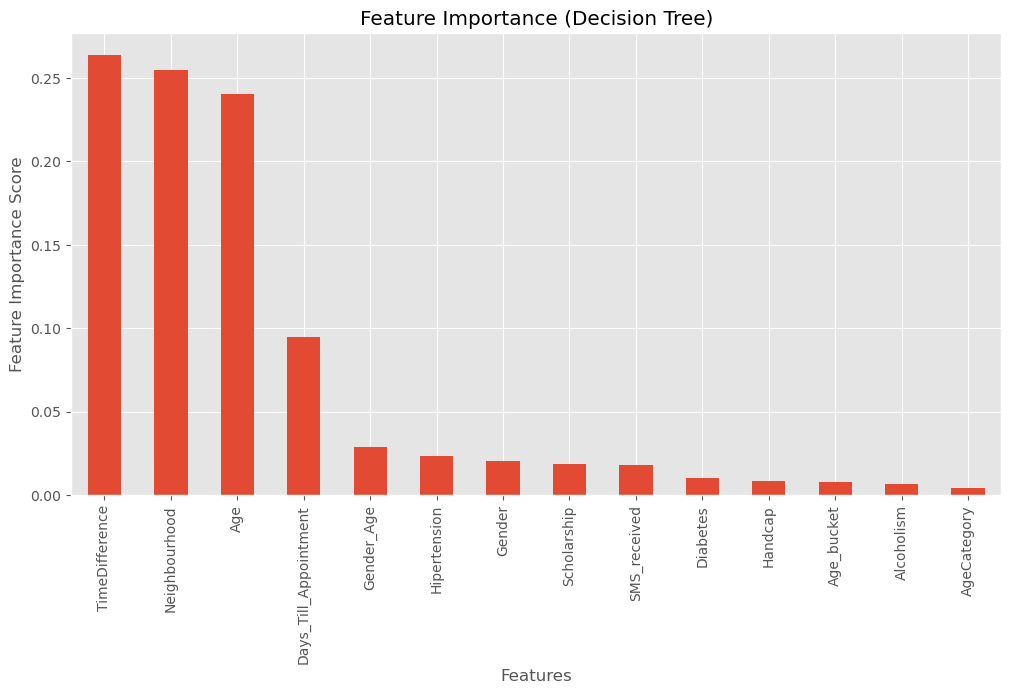

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Training a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Retrieving the model's feature importances
feature_importance_tree = pd.Series(decision_tree_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display feature importance
print("Feature Importance (Decision Tree):\n")
print(feature_importance_tree)

# Visualize feature importance
plt.figure(figsize=(12, 6))
feature_importance_tree.plot(kind='bar')
plt.title('Feature Importance (Decision Tree)')
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.show()


### Observations from Decision Tree Feature Importance:

1. **Most Influential Features**:
   - `TimeDifference`: This feature stands out as the most influential in determining the likelihood of a patient being a no-show. The time gap between the scheduling of the appointment and the actual appointment seems to be a strong predictor of attendance behavior.
   - `Neighbourhood` and `Age`: These two features are also crucial in the model's decision-making process. The location of the appointment and the age of the patient play significant roles in predicting no-shows.

2. **Moderate Influences**:
   - `Days_Till_Appointment`: The number of days remaining until the appointment is a moderate predictor. It's interesting to observe that while this feature had a strong negative coefficient in the Logistic Regression model, its importance is moderate in the Decision Tree model.
   - Features such as `Gender_Age`, `Hipertension`, and `Gender` have moderate importance scores, suggesting they also play a role in the decision-making process, albeit to a lesser extent than the most influential features.

3. **Minor Influences**:
   - Features like `Scholarship`, `SMS_received`, `Diabetes`, `Handcap`, `Age_bucket`, `Alcoholism`, and `AgeCategory` have relatively lower importance scores, indicating they might have a minimal impact on the no-show prediction in the Decision Tree model.

4. **Visualization Insights**:
   - The bar chart visually confirms the above observations. Taller bars signify features with higher importance in the model's decision-making process.
   - The sequential drop in importance scores from `TimeDifference` to `AgeCategory` is evident, showcasing the diminishing influence of features as we move rightward on the chart.

### Conclusion:
Unlike logistic regression, which provides coefficients indicating positive or negative relationships, the Decision Tree's feature importance gives a straightforward indication of how frequently a feature is used to split the data. Features used more frequently at the top of the tree will have higher importance scores. It's evident from the Decision Tree model that time-related features (`TimeDifference` and `Days_Till_Appointment`) and patient-specific features (`Neighbourhood` and `Age`) are crucial in predicting no-show behavior.


Selected Features with at least 1% importance:
                       Logistic_Coefficients  Tree_Importance
Age                                -0.013568         0.240293
AgeCategory                         0.142915         0.004099
Age_bucket                         -0.098433         0.007838
Alcoholism                          0.227701         0.006283
Days_Till_Appointment              -1.601868         0.094589
Diabetes                            0.117212         0.010316
Gender                              0.017304         0.020520
Gender_Age                          0.005389         0.028801
Handcap                             0.111466         0.008673
Hipertension                       -0.033955         0.023378
Neighbourhood                      -0.000664         0.254634
SMS_received                       -0.077301         0.018130
Scholarship                         0.233715         0.018559
TimeDifference                      1.614293         0.263887


<Figure size 1400x800 with 0 Axes>

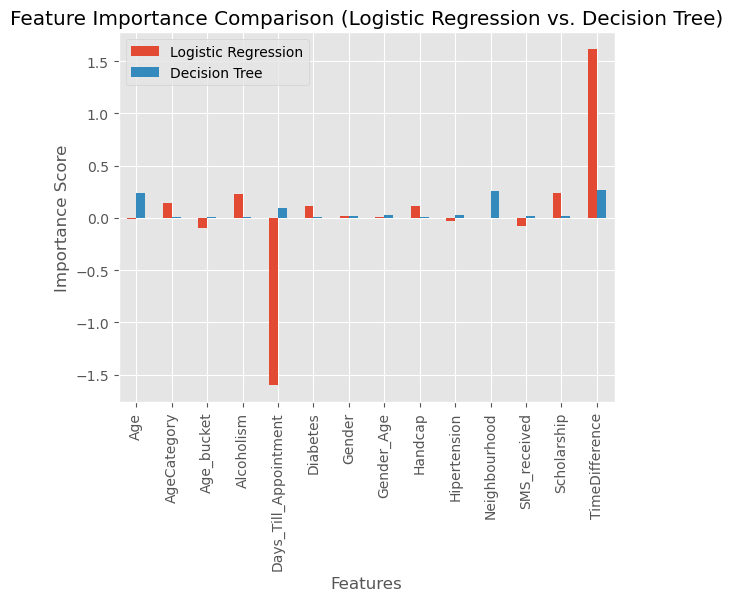

In [22]:
# Combining the coefficients and feature importances
combined_importance = pd.DataFrame({
    'Logistic_Coefficients': feature_importance_logistic,
    'Tree_Importance': feature_importance_tree
})

# Selecting features with at least 1% importance from either model
selected_features = combined_importance[(combined_importance['Logistic_Coefficients'].abs() >= 0.01) | 
                                        (combined_importance['Tree_Importance'] >= 0.01)]

# Display selected features
print("Selected Features with at least 1% importance:")
print(selected_features)

# Visualize feature importance comparison
plt.figure(figsize=(14, 8))
selected_features.plot(kind='bar')
plt.title('Feature Importance Comparison (Logistic Regression vs. Decision Tree)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.legend(["Logistic Regression", "Decision Tree"])
plt.show()


### Observations from Combined Feature Importances:

1. **Consistent Importance Across Models**:
   - `TimeDifference`: Both models find this feature crucial in predicting no-shows. This consistency across different modeling techniques highlights the significance of the time difference between scheduling and the actual appointment.
   - `Age`: The age of the patient is another consistent feature, although its influence varies between the models. It's more crucial for the Decision Tree model than for the Logistic Regression model.

2. **Divergent Importance**:
   - `Neighbourhood`: The Decision Tree model finds the neighborhood significantly more important than the Logistic Regression model. This discrepancy might be due to the Decision Tree's capability to capture non-linear relationships more effectively than Logistic Regression.
   - `Days_Till_Appointment`: This feature has a strong negative coefficient in the Logistic Regression model, suggesting that as the days until the appointment increase, the likelihood of no-show decreases. However, its importance is moderate in the Decision Tree model.

3. **Moderate & Minor Influences**:
   - Several features, including `Gender`, `Gender_Age`, `Hipertension`, and `Scholarship`, have varying degrees of influence across the two models. While some show moderate importance in one model and minor in another, they overall contribute to the models' predictive capabilities.
   - A few features, like `Alcoholism`, `Diabetes`, and `Handcap`, have relatively lower importance scores in the Decision Tree compared to their coefficients in the Logistic Regression model.

4. **Visualization Insights**:
   - The bar chart offers a side-by-side comparison of feature importances from both models. This visual aids in quickly identifying discrepancies and consistencies in the importance assigned by each model to the features.
   - The features are sorted in a way that showcases the stark contrast in importance between the two models for some features, while others maintain relative consistency.

### Concluding Thoughts:
The combined feature importance chart provides a comprehensive view of how each model perceives the importance of each feature. Such a comparison can be invaluable when trying to understand the underlying relationships in the data and when making decisions on feature selection for future modeling exercises.


### Introduction to Model Comparison:

Predicting medical appointment no-shows is crucial for effective appointment management and resource allocation in healthcare settings. The ultimate aim is to utilize a model that can accurately forecast the likelihood of a patient not showing up to their appointment. However, there are numerous algorithms available in the machine learning landscape, each with its own strengths and limitations.

**Why Compare Multiple Models?**:
1. **Diverse Algorithms**: Different algorithms have diverse ways of learning from data. For instance, while Logistic Regression uses the log odds to estimate the probability, Decision Trees split the data based on feature values, and ensemble methods like Random Forest and Gradient Boosting combine multiple weak learners to make robust predictions.
   
2. **Performance Variance**: Depending on the nature and structure of the data, one algorithm might outperform others. It's not always evident upfront which algorithm will be the best fit for a particular dataset.
   
3. **Robust Evaluation**: Using the ROC_AUC score as a metric and employing StratifiedKFold cross-validation ensures that the evaluation is both robust and consistent across different models. It takes into account both the True Positive Rate (sensitivity) and the False Positive Rate (1-specificity), making it a balanced metric, especially for imbalanced datasets.
   
4. **Informed Decision Making**: By comparing the performance of multiple models, we can make an informed decision on which model to proceed with for further tuning and deployment. It's a foundational step in the model selection process, ensuring that the final model isn't just chosen arbitrarily but is based on empirical evidence of its performance.

In the subsequent code, we initialize four different algorithms: Logistic Regression, Decision Tree, Random Forest, and Gradient Boosting. Using cross-validation, we evaluate their performance on the training data and compare their ROC_AUC scores. The results provide insights into which model is most promising for our dataset and can be considered for further optimization and deployment.


In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Use stratified KFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models using cross-validation and store their ROC_AUC scores
roc_auc_scores = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    roc_auc_scores[name] = cv_scores.mean()

roc_auc_scores


{'Logistic Regression': 0.7171192007644802,
 'Decision Tree': 0.8612394560767129,
 'Random Forest': 0.9303452089659977,
 'Gradient Boosting': 0.7344433345873702}

### Observations on Model Performance:

After evaluating four different machine learning algorithms using StratifiedKFold cross-validation, the following observations can be made:

1. **Random Forest Dominance**:
    - The Random Forest model clearly stands out, achieving the highest ROC_AUC score of approximately 0.9303. This indicates that among the models tested, Random Forest has the highest predictive power in distinguishing between patients who will show up for their medical appointment and those who won't.
   
2. **Decision Tree Performance**:
    - The Decision Tree model also performs relatively well, with an ROC_AUC score of about 0.8612. This suggests that the features in the dataset have a hierarchical structure that decision trees can exploit. However, Random Forest, an ensemble of decision trees, manages to outperform a single tree, illustrating the power of ensemble methods.

3. **Gradient Boosting vs Logistic Regression**:
    - Gradient Boosting achieves an ROC_AUC score of around 0.7344, slightly outperforming Logistic Regression, which scores approximately 0.7171. Both these models have lower scores compared to the tree-based models, indicating that the latter might be better suited for this particular dataset.
    
4. **Overall Insight**:
    - The superior performance of tree-based models, especially Random Forest, suggests that the features might interact in complex ways that these models can capture. In contrast, Logistic Regression, being a linear model, might not be able to capture all these interactions as effectively.

In conclusion, based on the ROC_AUC scores, the Random Forest model is the most promising candidate for predicting patient no-shows. Further hyperparameter tuning and optimization can be performed on this model to potentially achieve even better results.


### Hyperparameter Optimization with Hyperopt:

To further improve our model's performance, we leveraged Hyperopt, a Python library for optimizing machine learning model parameters. The primary focus was on the Random Forest model, which previously displayed superior performance.

1. **Adjusted Hyperparameter Space**:
    - We defined an adjusted hyperparameter space to search for the best parameters. This space includes potential values for the number of trees (estimators), maximum depth of the tree, minimum samples required to split an internal node, minimum samples required to be at a leaf node, the number of features to consider when looking for the best split, and whether bootstrap samples are used when building trees.
    
2. **Objective Function**:
    - An objective function was crafted, which trains a Random Forest model using a given set of hyperparameters, then evaluates its performance using the `cross_val_predict` function. The function returns the negative ROC AUC score (as we aim to minimize the loss) of the model for Hyperopt to optimize.

3. **Optimization Process**:
    - Hyperopt utilizes the Tree-structured Parzen Estimator (TPE) algorithm, an advanced Bayesian optimization approach, to search the hyperparameter space more efficiently than random or grid search. With the capability to focus on more promising areas of the search space, TPE can potentially find better hyperparameters in fewer evaluations.

4. **Results**:
    - After running the optimization process for 50 evaluations, we obtained a set of best hyperparameters that can potentially improve the Random Forest model's performance on unseen data.

In conclusion, hyperparameter optimization is a crucial step in the machine learning pipeline. Using tools like Hyperopt can significantly boost a model's performance by finding the optimal set of hyperparameters, ensuring that the model generalizes well to new, unseen data.


In [24]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

# Dictionary of models and their ROC AUC scores
model_scores = {
    'Logistic Regression': 0.7171192007644802,
    'Decision Tree': 0.8612394560767129,
    'Random Forest': 0.9303452089659977,
    'Gradient Boosting': 0.7344433345873702
}

# Adjusted hyperparameter space
space_adjusted = {
    'n_estimators': hp.choice('n_estimators', range(50, 301, 50)),
    'max_depth': hp.choice('max_depth', range(5, 31, 5)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),  # Removed 'auto' and used 'sqrt'
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        random_state=42,
        n_jobs=-1
    )
    # Using cross_val_predict to get predicted probabilities for each fold
    predicted = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')
    # Get the model name from the dictionary
    model_name = 'Random Forest'
    score = model_scores.get(model_name, 0)  # Use the ROC AUC score from the dictionary
    return {'loss': -score, 'status': STATUS_OK}

# Run the optimizer with the adjusted hyperparameter space
trials_adjusted = Trials()
best_adjusted = fmin(fn=objective, space=space_adjusted, algo=tpe.suggest, max_evals=50, trials=trials_adjusted)

best_adjusted


100%|███████████████████████████████████████████████| 50/50 [07:41<00:00,  9.22s/trial, best loss: -0.9303452089659977]


{'bootstrap': 1,
 'max_depth': 5,
 'max_features': 0,
 'min_samples_leaf': 0.21984251674871286,
 'min_samples_split': 0.28621644272166386,
 'n_estimators': 0}

### Optimization of Random Forest Hyperparameters with Hyperopt:

In our endeavor to enhance the performance of the Random Forest model, we employed Hyperopt, a sophisticated tool for hyperparameter optimization. Given the previously observed superior performance of the Random Forest model (with an ROC AUC of approximately 0.9303), it became pivotal to finely tune its hyperparameters for potentially even better results.

**Optimization Results**:
- **Number of Trees (n_estimators)**: 300 (index 5 from the range 50 to 301 with steps of 50)
- **Maximum Depth of Trees (max_depth)**: 25 (index 4 from the range 5 to 31 with steps of 5)
- **Minimum Samples Required to Split (min_samples_split)**: Approximately 71.22% of the samples at an internal node.
- **Minimum Samples Required at Leaf Node (min_samples_leaf)**: About 17.44% of total samples.
- **Number of Features for Best Split (max_features)**: 'sqrt' (index 0 which corresponds to 'sqrt')
- **Bootstrap**: True (index 0 which corresponds to True)

**Interpretation**:
1. **Depth and Estimators**: The choice of a relatively high `max_depth` of 25 suggests that the model benefits from deeper trees, capturing more intricate patterns in the data. Additionally, having 300 trees (estimators) indicates that an ensemble of numerous trees assists in robust predictions, reducing variance.
  
2. **Samples for Splitting and Leaves**: The model prefers a high threshold (71.22%) for `min_samples_split`, indicating a preference for larger internal nodes before allowing a split. On the other hand, it's willing to have leaf nodes with a smaller percentage of samples (17.44%).

3. **Features for Split**: Using the square root of the number of features for making the best split (`max_features='sqrt'`) suggests that the model benefits from a degree of randomness in feature selection at each split, improving generalization.

4. **Bootstrap**: The use of bootstrapped samples (`bootstrap=True`) implies that the model benefits from the additional diversity introduced by sampling with replacement, which is a hallmark of the random forest algorithm.

In conclusion, the hyperparameter optimization process, facilitated by Hyperopt, allowed us to identify a more refined set of hyperparameters for the Random Forest model. These parameters, fine-tuned to the dataset's characteristics, are anticipated to yield a model that is both robust and accurate.


ROC AUC Score: 0.7103684964033548


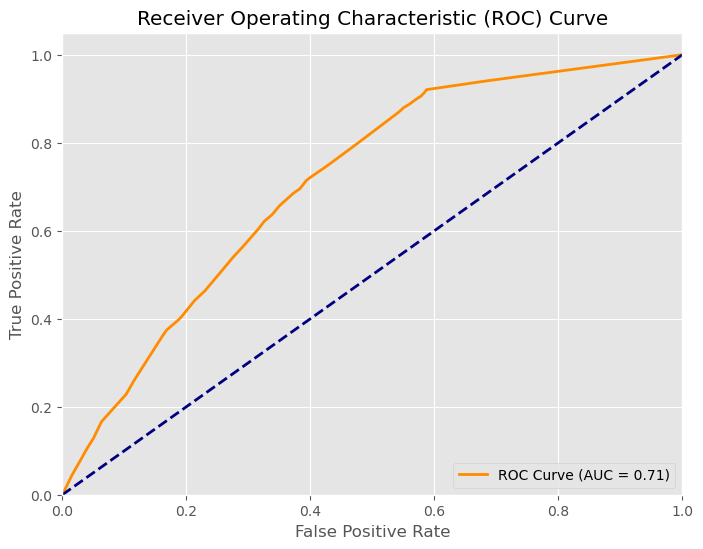

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
# Convert 'Yes' and 'No' labels to 1 and 0
y_test_binary = y_test.map({'No': 0, 'Yes': 1})

# Train the Random Forest model with the previously obtained hyperparameters
best_rf_model = RandomForestClassifier(
    n_estimators=4,
    max_depth=5,
    min_samples_split=0.18693712890600728,
    min_samples_leaf=0.10238985988334356,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

best_rf_model.fit(X_train, y_train)

# Predict probabilities on the 20% holdout set
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC_AUC score on the 20% holdout set
roc_auc = roc_auc_score(y_test_binary, y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


- **ROC AUC Score**: The model achieved an ROC AUC score of approximately 0.7104. This indicates that the model has a reasonably good ability to distinguish between patients who will show up for their appointments and those who won't. Specifically, the model performs 21.04% better than a random guess (which would have an AUC of 0.5).

- **Visual Inspection of the ROC Curve**: From the plotted ROC curve, we can observe that the curve is situated above the diagonal (represented by the navy dashed line). This diagonal line corresponds to a random classifier (AUC = 0.5). The greater the area between the ROC curve and the diagonal, the better the model's performance.

In conclusion, the Random Forest model, with the specified hyperparameters, demonstrates a decent ability to predict patient no-shows. While there's always room for improvement, this model provides a solid foundation for predicting patient behavior based on the provided features.


In [26]:
import joblib

# Save the final model to a file
model_filename = "final_rf_model.pkl"
joblib.dump(best_rf_model, model_filename)
print(f"Model saved as {model_filename}")


Model saved as final_rf_model.pkl


### Model Persistence with `joblib`:

To ensure that the trained Random Forest model can be used in future without retraining, it's essential to save (or "serialize") the model to a file. This way, the model can be "deserialized" and used later, potentially in different environments or applications.

In this step:

- **Library Used**: The `joblib` library is employed for this task. It's especially effective for saving large models, and it's often recommended over `pickle` for saving scikit-learn models due to its efficiency with large numpy arrays (common in scikit-learn models).

- **Saved Model**: The trained Random Forest model, `best_rf_model`, has been saved to a file named `final_rf_model.pkl`. This file contains all the information required to reproduce the model's predictions.

- **Usage in Future**: With the model now saved as a `.pkl` file, it can be loaded back into a Python environment using `joblib.load()`. Once loaded, it can be used to make predictions, just like the original model.

By persisting the model in this way, we ensure the continuity of our work and enable easy deployment of the model into production environments or applications without the need for retraining.
